In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"SUCCESS: {len(gpus)} GPU(s) detected!")
    print(f"Device Name: {gpus[0].name}")
else:
    print(" ERROR: No GPU detected. You are running on CPU.")

2026-01-01 17:40:26.364811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767289226.538315      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767289226.588421      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767289227.011228      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767289227.011273      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767289227.011276      55 computation_placer.cc:177] computation placer alr

SUCCESS: 2 GPU(s) detected!
Device Name: /physical_device:GPU:0


In [3]:
import os
import shutil
import tarfile
from tqdm.notebook import tqdm


working_dir = "/kaggle/working/"

for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    if os.path.isfile(item_path) or os.path.islink(item_path):
        os.remove(item_path)
    elif os.path.isdir(item_path):
        shutil.rmtree(item_path)
print("Cleaned working directory.")

tar_path = "/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar"
extract_path = "/kaggle/working/BraTS2021"

if not os.path.exists(extract_path):
    os.makedirs(extract_path)
    print("Extracting tar file... (This takes 2-5 mins)")
    with tarfile.open(tar_path, "r") as tar:
    
        members = tar.getmembers()
        for member in tqdm(members, desc="Extracting files"):
            tar.extract(member, path=extract_path)
    print("Extraction Complete.")
else:
    print("Dataset already extracted.")

Cleaned working directory.
Extracting tar file... (This takes 2-5 mins)


Extracting files:   0%|          | 0/7508 [00:00<?, ?it/s]

/tmp/ipykernel_55/2083306841.py:27: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extract(member, path=extract_path)


Extraction Complete.


In [4]:
import nibabel as nib
import numpy as np
import cv2
import matplotlib.pyplot as plt


DATA_DIR = "/kaggle/working/BraTS2021"
PROCESSED_DIR = "/kaggle/working/processed_unet"
IMAGES_DIR = os.path.join(PROCESSED_DIR, "images")
MASKS_DIR = os.path.join(PROCESSED_DIR, "masks")

os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(MASKS_DIR, exist_ok=True)


patients = sorted([p for p in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, p))])


PATIENT_LIMIT = 100 

print(f"Processing {PATIENT_LIMIT} patients out of {len(patients)}...")

slice_count = 0

for patient in tqdm(patients[:PATIENT_LIMIT], desc="Processing Patients"):
    patient_path = os.path.join(DATA_DIR, patient)
    
   
    flair_path = os.path.join(patient_path, f"{patient}_flair.nii.gz")
    seg_path = os.path.join(patient_path, f"{patient}_seg.nii.gz")
    
    if not os.path.exists(flair_path) or not os.path.exists(seg_path):
        continue
        
  
    flair_vol = nib.load(flair_path).get_fdata()
    seg_vol = nib.load(seg_path).get_fdata()
    

    flair_vol = cv2.normalize(flair_vol, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    

    for i in range(30, 120): 
        mask_slice = seg_vol[:, :, i]
        img_slice = flair_vol[:, :, i]
    
        if np.max(mask_slice) > 0:
            
     
            binary_mask = np.zeros_like(mask_slice)
            binary_mask[mask_slice > 0] = 255 # 255 for white pixel
            binary_mask = binary_mask.astype(np.uint8)
            
        
            img_resized = cv2.resize(img_slice, (128, 128))
            mask_resized = cv2.resize(binary_mask, (128, 128), interpolation=cv2.INTER_NEAREST)
            
        
            filename = f"{patient}_slice_{i}.png"
            cv2.imwrite(os.path.join(IMAGES_DIR, filename), img_resized)
            cv2.imwrite(os.path.join(MASKS_DIR, filename), mask_resized)
            
            slice_count += 1

print(f"Preprocessing Done. Created {slice_count} slices.")

Processing 100 patients out of 1251...


Processing Patients:   0%|          | 0/100 [00:00<?, ?it/s]

Preprocessing Done. Created 6068 slices.


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout
from tensorflow.keras.models import Model

def build_unet(input_shape=(128, 128, 1)):
    inputs = Input(input_shape)
    
    #  ENCODER 

    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # BOTTLENECK 
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

    # DECODER 
  
    u5 = UpSampling2D((2, 2))(c4)
    u5 = Concatenate()([u5, c3])
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c1]) 
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

  
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    return Model(inputs=[inputs], outputs=[outputs])


model = build_unet()
model.summary()

I0000 00:00:1767289409.688929      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767289409.693440      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 64, 64,    │          0 │ conv2d_9[0][0]  

 Total params: 1,946,305 (7.42 MB)

 Trainable params: 1,946,305 (7.42 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from sklearn.model_selection import train_test_split

images_list = sorted(os.listdir(IMAGES_DIR))
masks_list = sorted(os.listdir(MASKS_DIR))

X = []
y = []

print("Loading data into memory...")
for img_name, mask_name in zip(images_list, masks_list):
   
    img = cv2.imread(os.path.join(IMAGES_DIR, img_name), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(os.path.join(MASKS_DIR, mask_name), cv2.IMREAD_GRAYSCALE)
    
 
    X.append(img / 255.0)
    y.append(mask / 255.0)


X = np.array(X).reshape(-1, 128, 128, 1)
y = np.array(y).reshape(-1, 128, 128, 1)


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

print("Starting Training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,  
    batch_size=32,
    verbose=1
)

Loading data into memory...
Starting Training...
Epoch 1/15


I0000 00:00:1767289428.507874     143 service.cc:152] XLA service 0x7f9880002980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767289428.507939     143 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767289428.507945     143 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767289429.460501     143 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-01-01 17:43:55.324637: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-01 17:43:55.612629: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-01 17:43:57.304744: E external/local_xl

  1/152 ━━━━━━━━━━━━━━━━━━━━ 59:24 24s/step - dice_coef: 0.0554 - loss: 0.6942

I0000 00:00:1767289448.048945     143 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - dice_coef: 0.2272 - loss: 0.1914

2026-01-01 17:44:31.253851: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-01 17:44:31.532920: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-01 17:44:32.924942: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-01 17:44:33.239650: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-01 17:44:33.523807: E external/local_xla/xla/stream_

152/152 ━━━━━━━━━━━━━━━━━━━━ 69s 298ms/step - dice_coef: 0.2298 - loss: 0.1900 - val_dice_coef: 0.7225 - val_loss: 0.0287
Epoch 2/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 22s 147ms/step - dice_coef: 0.7406 - loss: 0.0270 - val_dice_coef: 0.7924 - val_loss: 0.0212
Epoch 3/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 23s 154ms/step - dice_coef: 0.8176 - loss: 0.0184 - val_dice_coef: 0.8347 - val_loss: 0.0162
Epoch 4/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 22s 148ms/step - dice_coef: 0.8522 - loss: 0.0148 - val_dice_coef: 0.8754 - val_loss: 0.0125
Epoch 5/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - dice_coef: 0.8817 - loss: 0.0120 - val_dice_coef: 0.8859 - val_loss: 0.0112
Epoch 6/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 23s 149ms/step - dice_coef: 0.8954 - loss: 0.0105 - val_dice_coef: 0.9020 - val_loss: 0.0099
Epoch 7/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 23s 151ms/step - dice_coef: 0.9071 - loss: 0.0094 - val_dice_coef: 0.9063 - val_loss: 0.0091
Epoch 8/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 23s 149ms/step - dice_coef: 0.9116 - los

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


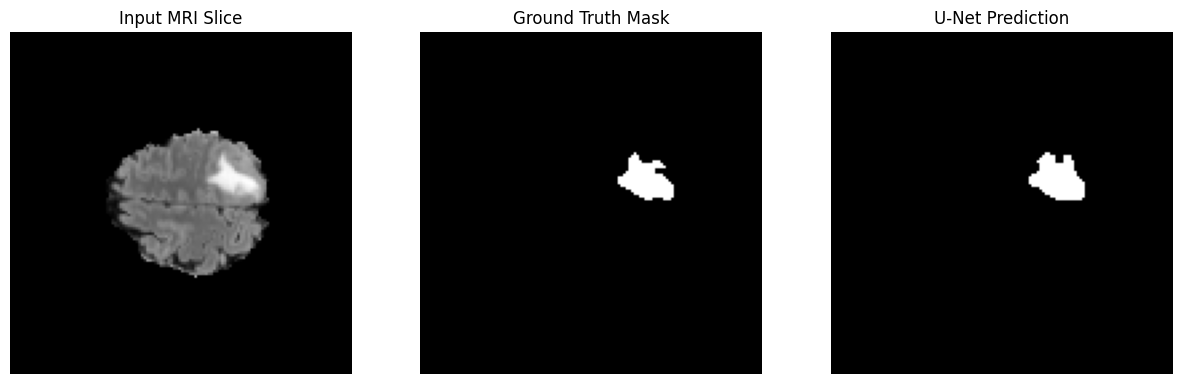

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


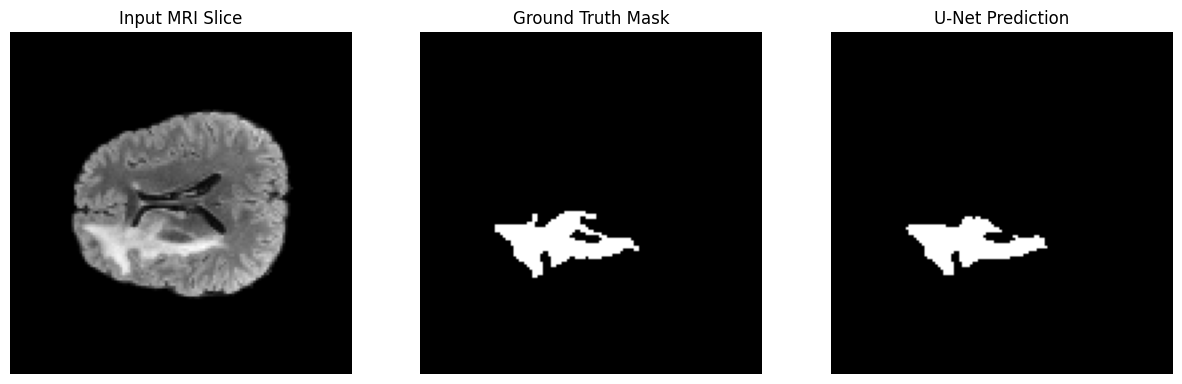

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


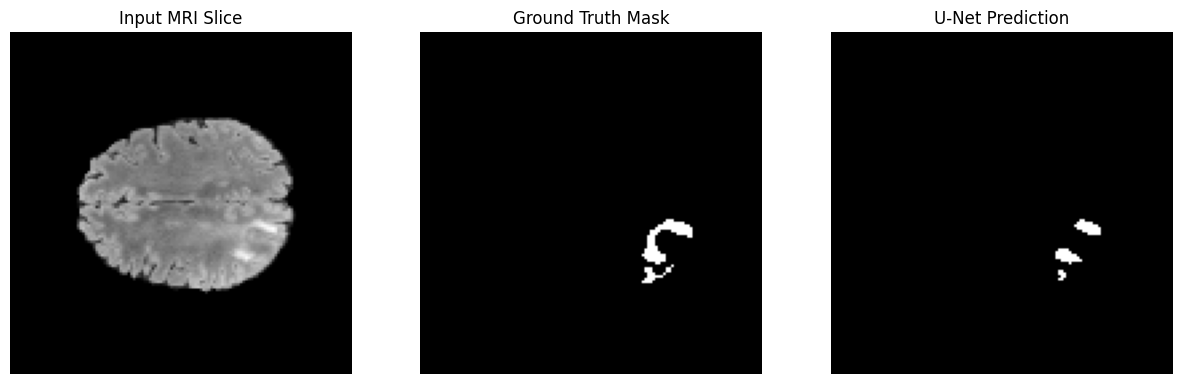

In [7]:

def visualize_prediction(index):
    img = X_val[index]
    true_mask = y_val[index]
    pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
    
   
    pred_mask_thresh = (pred_mask > 0.5).astype(np.uint8)
    
    plt.figure(figsize=(15, 5))
    
   
    plt.subplot(1, 3, 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title("Input MRI Slice")
    plt.axis('off')
    
 
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')
    
 
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask_thresh.squeeze(), cmap='gray')
    plt.title("U-Net Prediction")
    plt.axis('off')
    
    plt.show()


import random
for i in range(3):
    idx = random.randint(0, len(X_val)-1)
    visualize_prediction(idx)